# Knee Osteoporosis Classification

### Environment Setup

#### Check GPU Availability

In [1]:
import torch

# Check if GPU (CUDA or Apple MPS) is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA (GPU)")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Metal GPU)")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU")

Using MPS (Apple Metal GPU)


 #### Install Required Packages

In [2]:
# pip install torch torchvision transformers matplotlib numpy

In [3]:
# ! pip install --upgrade pip

In [4]:
# !pip install --upgrade transformers tokenizers

In [5]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

### Data Preparation

#### Load and Transform Dataset

In [6]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler

# Define transformations (Augmentations for TRAINING ONLY)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomRotation(degrees=10),  # Small random rotation
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance to flip
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Small shifts
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust contrast
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # Adjusted for medical images
])

# **Validation & Test Transform (NO Augmentations)**
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # Same normalization as train
])

# Load dataset
dataset_path = "/Users/gideonbonwitt/Documents/Msc/Final Project/datasets/cropped_data"
full_dataset = datasets.ImageFolder(root=dataset_path)

# Split dataset into Train (70%), Validation (15%), and Test (15%)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])

# **Apply Transforms to Each Split**
train_set.dataset.transform = train_transform
val_set.dataset.transform = eval_transform
test_set.dataset.transform = eval_transform

# **Compute Class Distribution for Weighted Sampling**
class_counts = torch.bincount(torch.tensor([label for _, label in full_dataset.samples]))

# **Ensure All Classes Exist (Avoid Zero-Division Errors)**
total_samples = sum(class_counts).item()
class_weights = total_samples / class_counts  # Inverse frequency weighting
sample_weights = torch.tensor([class_weights[label] for _, label in full_dataset.samples])

# **Apply WeightedRandomSampler ONLY to Training Set**
train_sampler = WeightedRandomSampler(
    sample_weights[train_set.indices], num_samples=len(train_set), replacement=True
)

# **DataLoaders (Batch Size & Sampler Only for Training)**
batch_size = 16
train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

### Model Selection and Training

#### Load Pretrained CNN Models

In [7]:
import torch.nn as nn
from torchvision import models

# Load and modify AlexNet
alexnet = models.alexnet(pretrained=True)

# Ensure we get the correct input size for the first fully connected (fc) layer
num_ftrs = alexnet.classifier[1].in_features  # This should be 9216

alexnet.classifier = nn.Sequential(
    nn.Dropout(0.3),  
    nn.Linear(num_ftrs, 4096),  # First FC layer
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(4096, 512),  # Second FC layer
    nn.ReLU(),
    nn.Linear(512, len(full_dataset.classes))  # Final output layer with correct num_labels
)

alexnet = alexnet.to(device)

print("✅ Fixed AlexNet Model Loaded!")

# Load and modify VGG19
vgg19 = models.vgg19(pretrained=True)

num_ftrs = vgg19.classifier[0].in_features  # Get correct input feature size

vgg19.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_ftrs, 4096),  
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Linear(512, len(full_dataset.classes))
)
vgg19 = vgg19.to(device)
print("✅ Fixed VGG19 Model Loaded!")

# Load and modify ResNet50
resnet = models.resnet50(pretrained=True)

num_ftrs = resnet.fc.in_features  # Get correct feature size

resnet.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),  
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(full_dataset.classes))
)

resnet = resnet.to(device)
print("✅ Fixed ResNet50 Model Loaded!")

/Users/gideonbonwitt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gideonbonwitt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Fixed AlexNet Model Loaded!


/Users/gideonbonwitt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Fixed VGG19 Model Loaded!


/Users/gideonbonwitt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Fixed ResNet50 Model Loaded!


#### Load Transformer-Based Vision Model (ViT)

In [8]:
from transformers import ViTForImageClassification, ViTImageProcessor

# Load ViT model and processor
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
vit = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(full_dataset.classes)
)
vit = vit.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Training Function

In [9]:
import time
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, epochs=10, lr=3e-5, weight_decay=1e-4, patience=3, model_name="Model"):
    """
    Trains a deep learning model with early stopping and learning rate scheduling.
    
    Args:
        model (torch.nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        epochs (int): Number of training epochs.
        lr (float): Initial learning rate.
        weight_decay (float): L2 regularization parameter.
        patience (int): Number of epochs to wait before stopping if no improvement.
        model_name (str): Name of the model (for logging).
    
    Returns:
        train_losses (list): Training loss per epoch.
        val_losses (list): Validation loss per epoch.
    """

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    # Move model to GPU if available
    model.to(device)

    train_losses = []
    val_losses = []
    best_val_loss = float("inf")
    early_stop_count = 0

    print(f"\n🚀 Training {model_name} for {epochs} epochs...\n")
    for epoch in range(epochs):
        start_time = time.time()
        running_loss = 0.0
        model.train()

        # Use tqdm for real-time progress updates
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
        batch_start_time = time.time()  # Track batch time

        for batch_idx, (inputs, labels) in enumerate(progress_bar):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.logits if hasattr(outputs, "logits") else outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item(), batch_time=f"{(time.time() - batch_start_time):.2f}s")
            batch_start_time = time.time()  # Reset batch timer

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.logits if hasattr(outputs, "logits") else outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Adjust learning rate if validation loss stagnates
        scheduler.step(avg_val_loss)

        # Track time taken for the epoch
        epoch_time = time.time() - start_time

        print(f"🕒 Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f} | Time: {epoch_time:.2f}s")

        # **Early Stopping**
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stop_count = 0  # Reset counter
        else:
            early_stop_count += 1
            print(f"⚠️ No improvement for {early_stop_count} epochs (Patience: {patience})")

        if early_stop_count >= patience:
            print("🚀 Early Stopping Triggered! Training Stopped.")
            break  # Stop training

    return train_losses, val_losses

In [10]:
# Function to plot training vs validation loss
def plot_loss_curve(train_losses, val_losses, model_name):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss", marker="o")
    plt.plot(val_losses, label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve for {model_name}")
    plt.legend()
    plt.show()


🚀 Training AlexNet for 15 epochs...



Epoch 1/15: 100%|█| 36/36 [00:05<00:00,  6.93it/s, batch_time=0.17s, loss=0.867]


🕒 Epoch 1/15 - Train Loss: 0.9677, Val Loss: 0.9434 | Time: 5.95s


Epoch 2/15: 100%|█| 36/36 [00:04<00:00,  7.98it/s, batch_time=0.07s, loss=0.459]


🕒 Epoch 2/15 - Train Loss: 0.7547, Val Loss: 0.9357 | Time: 5.14s


Epoch 3/15: 100%|█| 36/36 [00:04<00:00,  8.12it/s, batch_time=0.06s, loss=0.388]


🕒 Epoch 3/15 - Train Loss: 0.6586, Val Loss: 1.1258 | Time: 5.05s
⚠️ No improvement for 1 epochs (Patience: 3)


Epoch 4/15: 100%|██| 36/36 [00:04<00:00,  8.08it/s, batch_time=0.06s, loss=0.49]


🕒 Epoch 4/15 - Train Loss: 0.5642, Val Loss: 1.0109 | Time: 5.07s
⚠️ No improvement for 2 epochs (Patience: 3)


Epoch 5/15: 100%|█| 36/36 [00:04<00:00,  8.20it/s, batch_time=0.05s, loss=0.217]


🕒 Epoch 5/15 - Train Loss: 0.4729, Val Loss: 0.9696 | Time: 5.04s
⚠️ No improvement for 3 epochs (Patience: 3)
🚀 Early Stopping Triggered! Training Stopped.


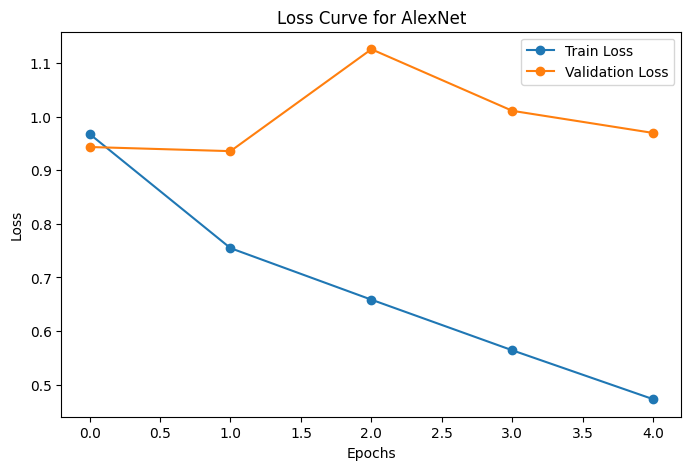


🚀 Training VGG19 for 15 epochs...



Epoch 1/15: 100%|█| 36/36 [00:22<00:00,  1.62it/s, batch_time=0.29s, loss=0.694]


🕒 Epoch 1/15 - Train Loss: 0.9176, Val Loss: 1.1098 | Time: 23.92s


Epoch 2/15: 100%|█| 36/36 [00:21<00:00,  1.65it/s, batch_time=0.23s, loss=0.573]


🕒 Epoch 2/15 - Train Loss: 0.7451, Val Loss: 0.8743 | Time: 23.47s


Epoch 3/15: 100%|█| 36/36 [00:21<00:00,  1.64it/s, batch_time=0.25s, loss=0.243]


🕒 Epoch 3/15 - Train Loss: 0.5671, Val Loss: 1.1765 | Time: 23.60s
⚠️ No improvement for 1 epochs (Patience: 3)


Epoch 4/15: 100%|█| 36/36 [00:22<00:00,  1.62it/s, batch_time=0.27s, loss=0.303]


🕒 Epoch 4/15 - Train Loss: 0.4454, Val Loss: 1.2643 | Time: 23.84s
⚠️ No improvement for 2 epochs (Patience: 3)


Epoch 5/15: 100%|█| 36/36 [00:21<00:00,  1.67it/s, batch_time=0.25s, loss=0.0153


🕒 Epoch 5/15 - Train Loss: 0.2785, Val Loss: 1.4254 | Time: 23.12s
⚠️ No improvement for 3 epochs (Patience: 3)
🚀 Early Stopping Triggered! Training Stopped.


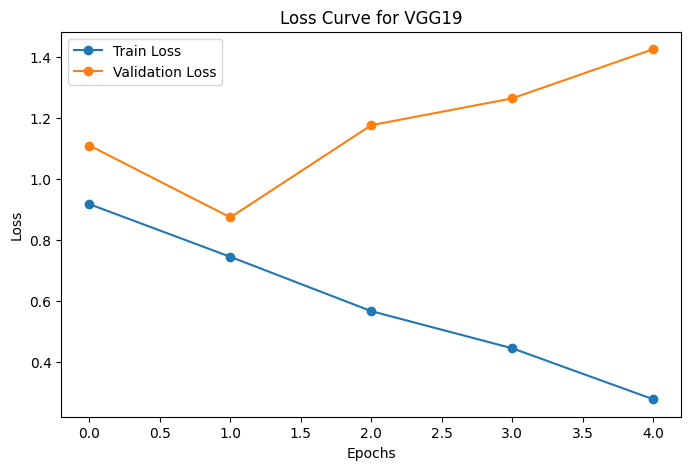


🚀 Training ResNet50 for 15 epochs...



Epoch 1/15: 100%|██| 36/36 [00:12<00:00,  2.97it/s, batch_time=0.61s, loss=1.02]


🕒 Epoch 1/15 - Train Loss: 0.9942, Val Loss: 1.0554 | Time: 13.45s


Epoch 2/15: 100%|██| 36/36 [00:10<00:00,  3.29it/s, batch_time=0.12s, loss=0.68]


🕒 Epoch 2/15 - Train Loss: 0.6906, Val Loss: 0.9307 | Time: 12.04s


Epoch 3/15: 100%|█| 36/36 [00:11<00:00,  3.20it/s, batch_time=0.12s, loss=0.478]


🕒 Epoch 3/15 - Train Loss: 0.4456, Val Loss: 0.8963 | Time: 12.33s


Epoch 4/15: 100%|█| 36/36 [00:10<00:00,  3.29it/s, batch_time=0.12s, loss=0.348]


🕒 Epoch 4/15 - Train Loss: 0.2290, Val Loss: 0.9740 | Time: 12.00s
⚠️ No improvement for 1 epochs (Patience: 3)


Epoch 5/15: 100%|█| 36/36 [00:10<00:00,  3.28it/s, batch_time=0.12s, loss=0.0681


🕒 Epoch 5/15 - Train Loss: 0.1121, Val Loss: 1.0636 | Time: 12.03s
⚠️ No improvement for 2 epochs (Patience: 3)


Epoch 6/15: 100%|█| 36/36 [00:10<00:00,  3.37it/s, batch_time=0.12s, loss=0.457]


🕒 Epoch 6/15 - Train Loss: 0.0992, Val Loss: 1.0991 | Time: 11.80s
⚠️ No improvement for 3 epochs (Patience: 3)
🚀 Early Stopping Triggered! Training Stopped.


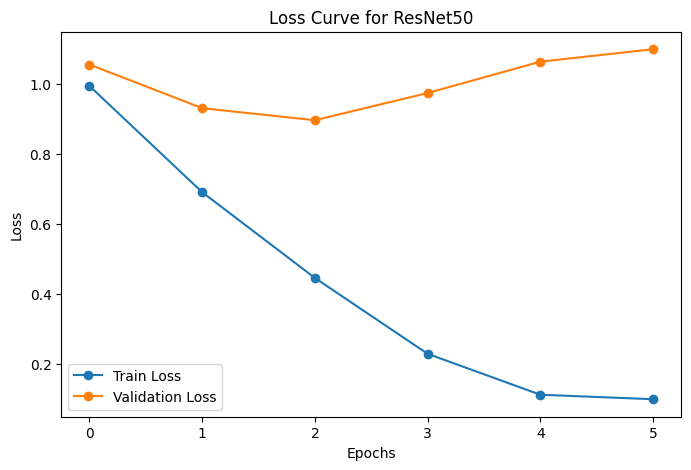


🚀 Training ViT for 15 epochs...



Epoch 1/15: 100%|██| 36/36 [00:23<00:00,  1.55it/s, batch_time=0.37s, loss=1.03]


🕒 Epoch 1/15 - Train Loss: 1.0613, Val Loss: 1.0711 | Time: 25.45s


Epoch 2/15: 100%|█| 36/36 [00:22<00:00,  1.57it/s, batch_time=0.23s, loss=0.633]


🕒 Epoch 2/15 - Train Loss: 0.9065, Val Loss: 1.0330 | Time: 25.08s


Epoch 3/15: 100%|█| 36/36 [00:22<00:00,  1.59it/s, batch_time=0.22s, loss=0.841]


🕒 Epoch 3/15 - Train Loss: 0.7202, Val Loss: 1.0261 | Time: 24.82s


Epoch 4/15: 100%|█| 36/36 [00:22<00:00,  1.60it/s, batch_time=0.22s, loss=0.236]


🕒 Epoch 4/15 - Train Loss: 0.5406, Val Loss: 1.2411 | Time: 24.74s
⚠️ No improvement for 1 epochs (Patience: 3)


Epoch 5/15: 100%|█| 36/36 [00:22<00:00,  1.60it/s, batch_time=0.22s, loss=0.434]


🕒 Epoch 5/15 - Train Loss: 0.4965, Val Loss: 1.0355 | Time: 24.68s
⚠️ No improvement for 2 epochs (Patience: 3)


Epoch 6/15: 100%|█| 36/36 [00:22<00:00,  1.58it/s, batch_time=0.23s, loss=0.185]


🕒 Epoch 6/15 - Train Loss: 0.3464, Val Loss: 1.0493 | Time: 24.91s
⚠️ No improvement for 3 epochs (Patience: 3)
🚀 Early Stopping Triggered! Training Stopped.


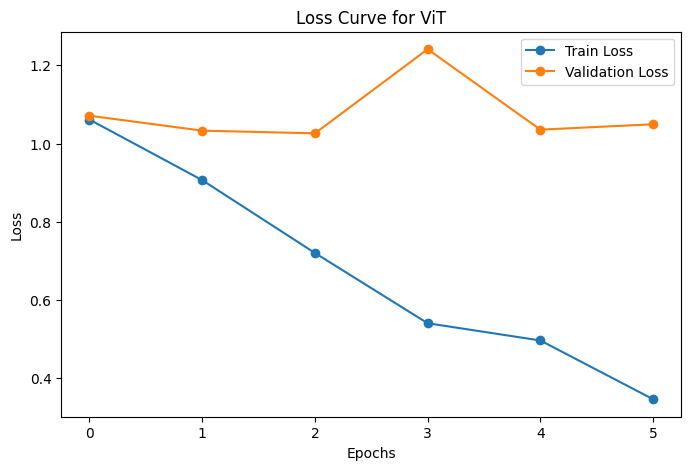

In [11]:
# Train AlexNet
train_losses, val_losses = train_model(alexnet, train_loader, val_loader, epochs=15, model_name="AlexNet")
plot_loss_curve(train_losses, val_losses, "AlexNet")

# Train VGG19
train_losses, val_losses = train_model(vgg19, train_loader, val_loader, epochs=15, model_name="VGG19")
plot_loss_curve(train_losses, val_losses, "VGG19")

# Train ResNet50
train_losses, val_losses = train_model(resnet, train_loader, val_loader, epochs=15, model_name="ResNet50")
plot_loss_curve(train_losses, val_losses, "ResNet50")

# Train ViT
train_losses, val_losses = train_model(vit, train_loader, val_loader, epochs=15, model_name="ViT")
plot_loss_curve(train_losses, val_losses, "ViT")

### Evaluate and Visualize Predictions

In [12]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Ensure Matplotlib is interactive
%matplotlib inline  

In [13]:
def evaluate_model(model, val_loader, class_names):
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            # Extract logits if model output contains a dictionary (e.g., ViT)
            logits = outputs.logits if hasattr(outputs, "logits") else outputs
            _, predicted = torch.max(logits, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')  # Macro for class-wise balance
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    # Calculate class-wise scores
    class_precision = precision_score(all_labels, all_preds, average=None)
    class_recall = recall_score(all_labels, all_preds, average=None)
    class_f1 = f1_score(all_labels, all_preds, average=None)

    # Print Overall Metrics
    print(f'Overall Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 Score: {f1 * 100:.2f}%')

    # Print Class-wise Performance
    print("\nClass-wise Performance:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name} - Precision: {class_precision[i] * 100:.2f}% | Recall: {class_recall[i] * 100:.2f}% | F1-Score: {class_f1[i] * 100:.2f}%")

    return accuracy, precision, recall, f1, all_preds, all_labels

In [14]:
def plot_confusion_matrix(all_labels, all_preds, class_names):
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(cmap='Blues', values_format='d', ax=ax)
    plt.title("Confusion Matrix")
    plt.show()

In [15]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall(all_labels, all_preds):
    precision, recall, _ = precision_recall_curve(all_labels, all_preds, pos_label=2)  # Osteoporosis as pos class

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()
    plt.show()

In [16]:
def visualize_predictions(model, data_loader, class_names):
    model.eval()
    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        logits = outputs.logits if hasattr(outputs, "logits") else outputs
        _, preds = torch.max(logits, 1)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Display 10 images

    for idx, ax in enumerate(axes.flatten()):
        if idx >= len(images):
            break
        img = images[idx].cpu().numpy().transpose((1, 2, 0))
        img = np.clip(img * 0.5 + 0.5, 0, 1)

        ax.imshow(img)
        ax.set_title(f"Pred: {class_names[preds[idx]]}\nTrue: {class_names[labels[idx]]}", fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


Evaluating AlexNet...

Overall Accuracy: 57.85%
Precision: 58.87%
Recall: 58.52%
F1 Score: 58.21%

Class-wise Performance:
Normal - Precision: 63.64% | Recall: 52.83% | F1-Score: 57.73%
Osteopenia - Precision: 50.00% | Recall: 64.10% | F1-Score: 56.18%
Osteoporosis - Precision: 62.96% | Recall: 58.62% | F1-Score: 60.71%


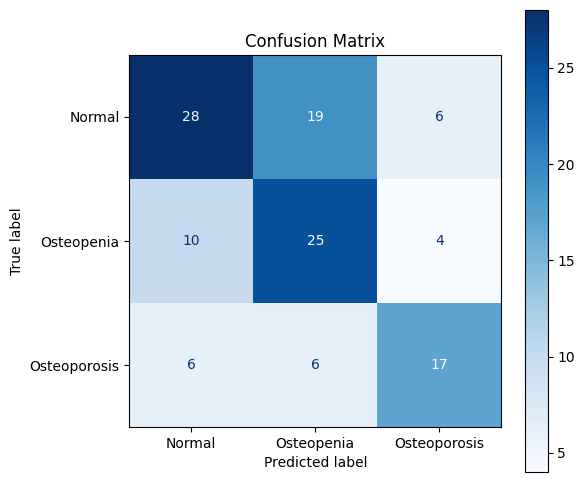

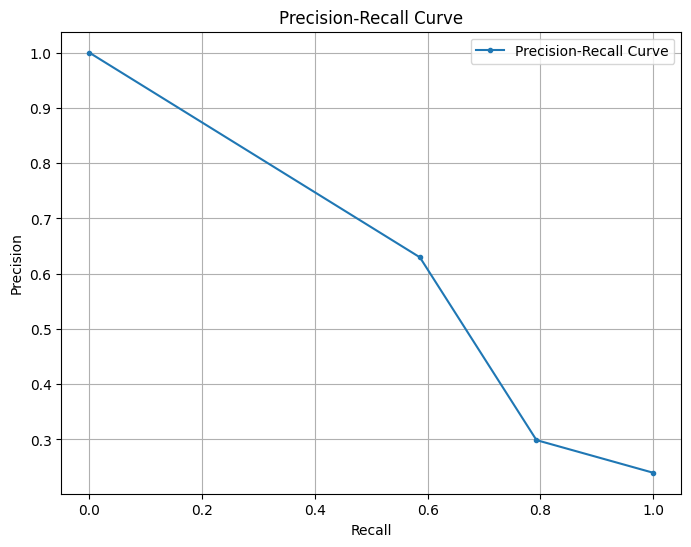

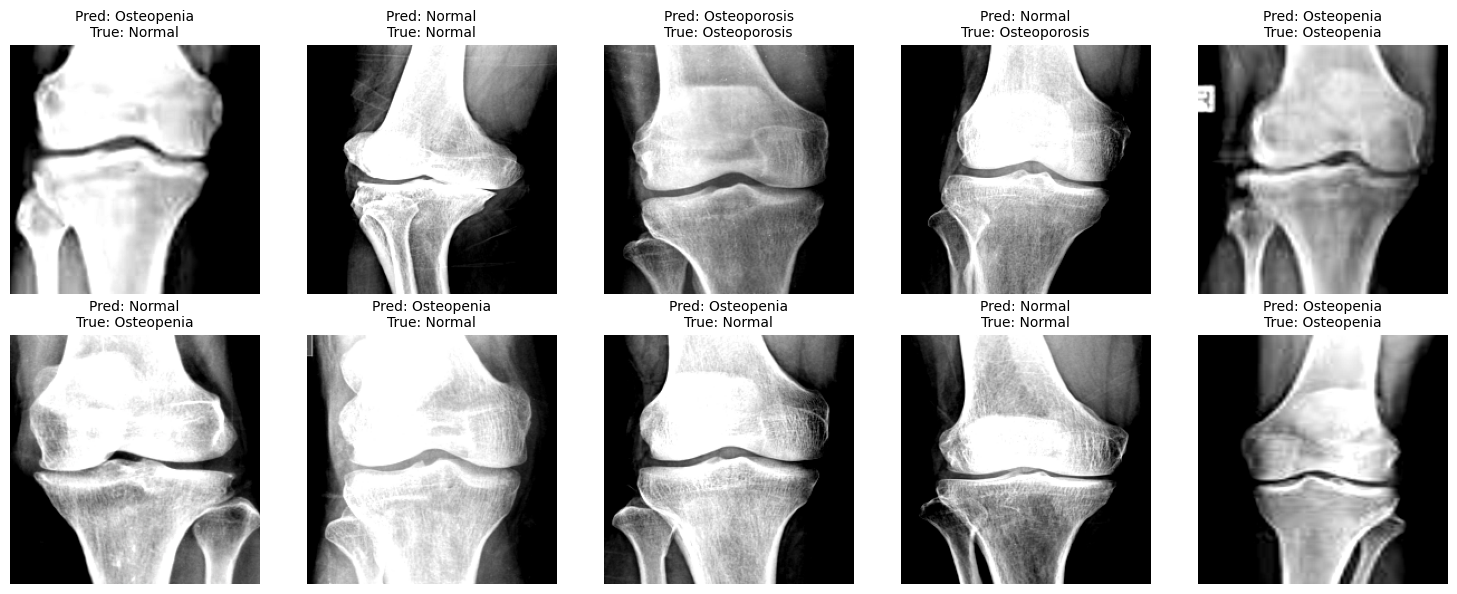


Evaluating VGG19...

Overall Accuracy: 51.24%
Precision: 51.88%
Recall: 52.29%
F1 Score: 51.27%

Class-wise Performance:
Normal - Precision: 63.16% | Recall: 45.28% | F1-Score: 52.75%
Osteopenia - Precision: 44.00% | Recall: 56.41% | F1-Score: 49.44%
Osteoporosis - Precision: 48.48% | Recall: 55.17% | F1-Score: 51.61%


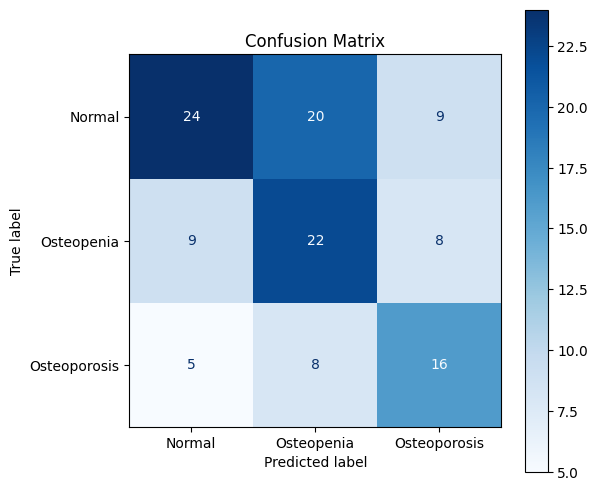

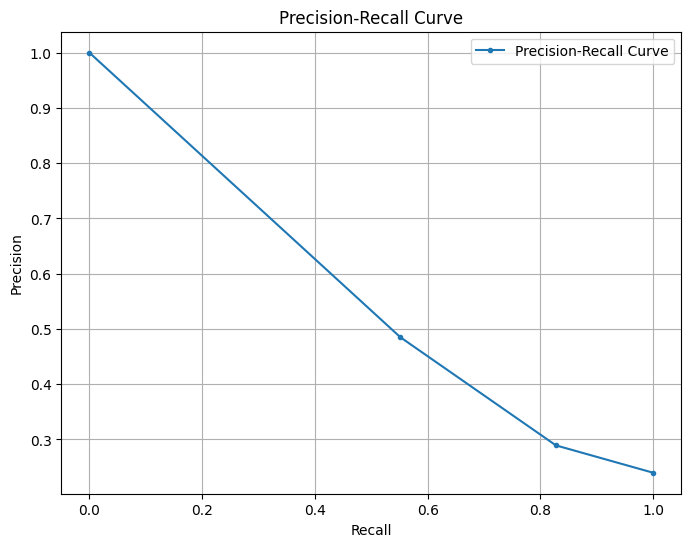

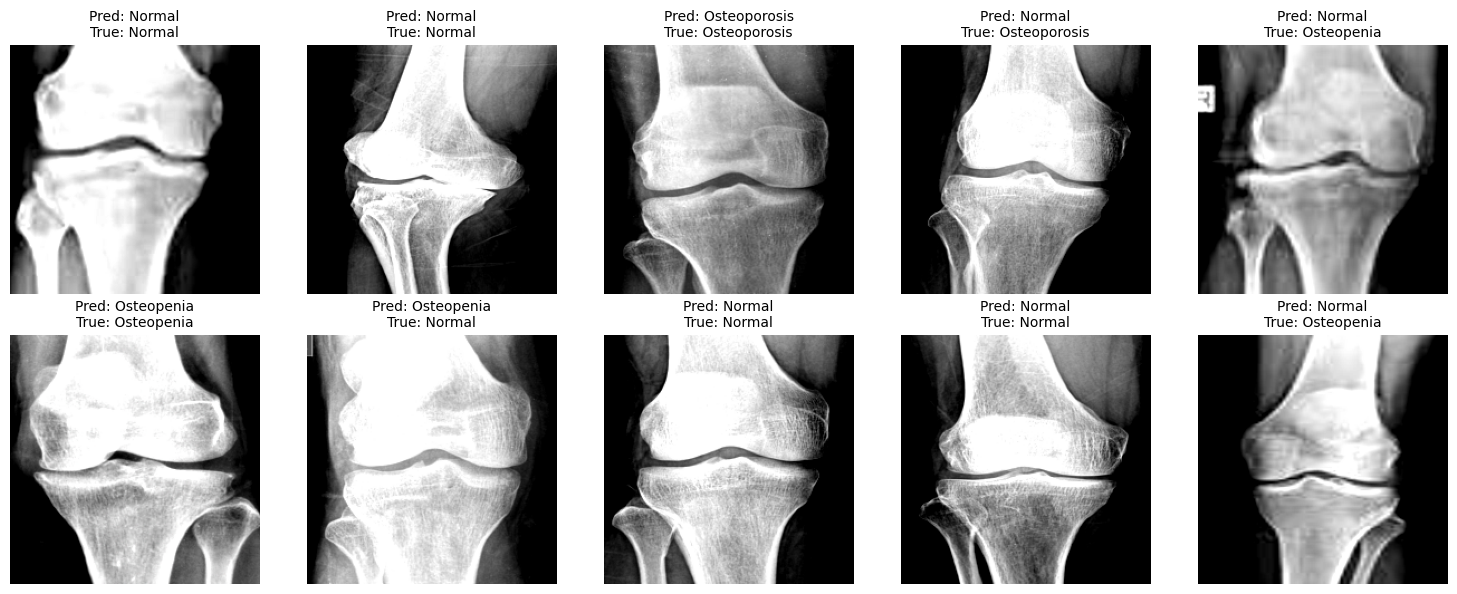


Evaluating ResNet50...

Overall Accuracy: 62.81%
Precision: 62.47%
Recall: 62.81%
F1 Score: 62.29%

Class-wise Performance:
Normal - Precision: 75.00% | Recall: 62.26% | F1-Score: 68.04%
Osteopenia - Precision: 54.35% | Recall: 64.10% | F1-Score: 58.82%
Osteoporosis - Precision: 58.06% | Recall: 62.07% | F1-Score: 60.00%


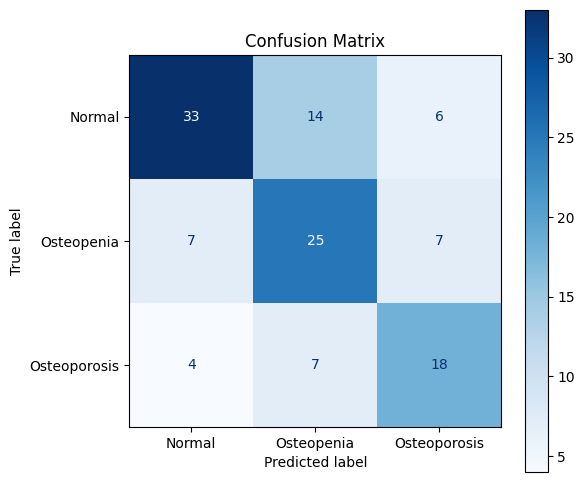

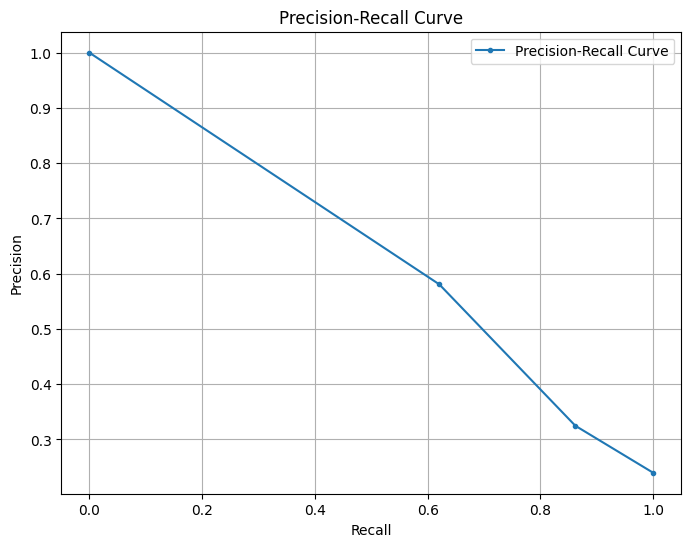

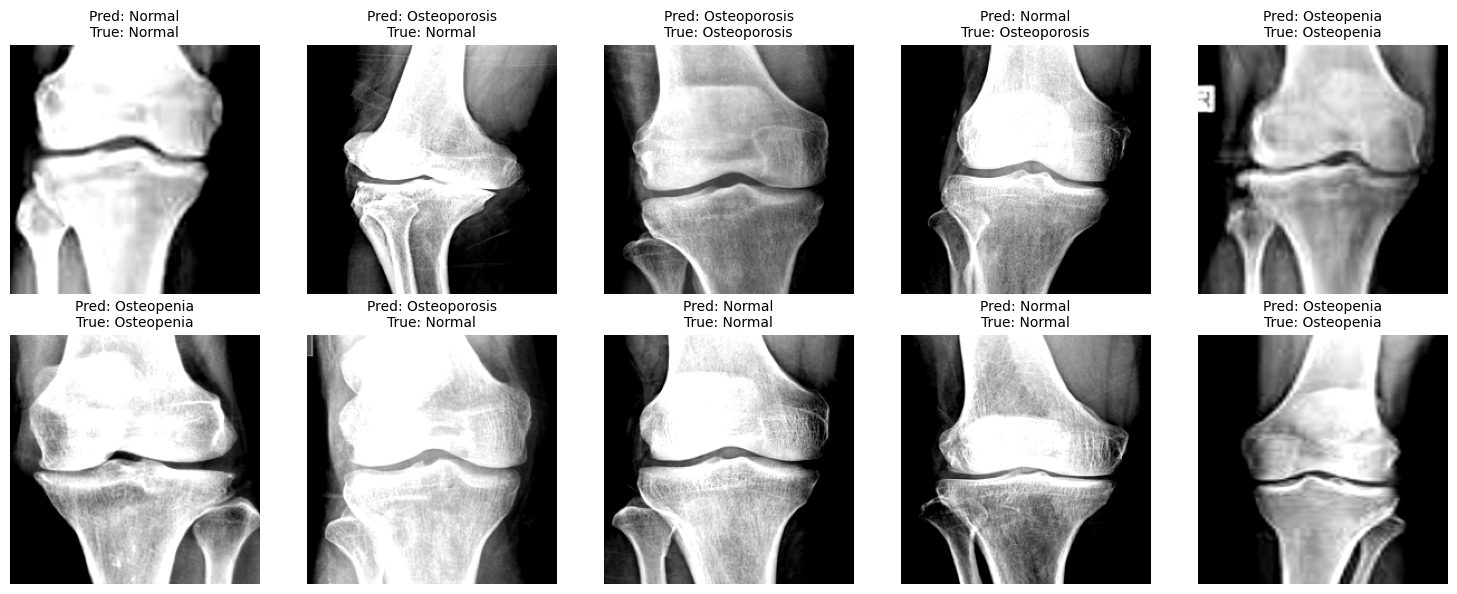


Evaluating ViT...

Overall Accuracy: 54.55%
Precision: 53.30%
Recall: 54.20%
F1 Score: 53.54%

Class-wise Performance:
Normal - Precision: 62.75% | Recall: 60.38% | F1-Score: 61.54%
Osteopenia - Precision: 48.57% | Recall: 43.59% | F1-Score: 45.95%
Osteoporosis - Precision: 48.57% | Recall: 58.62% | F1-Score: 53.12%


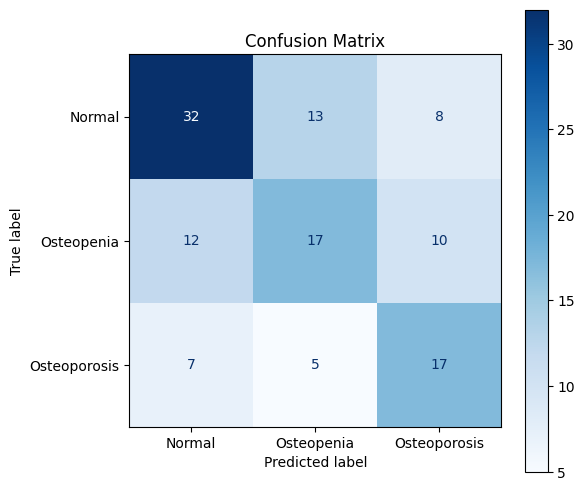

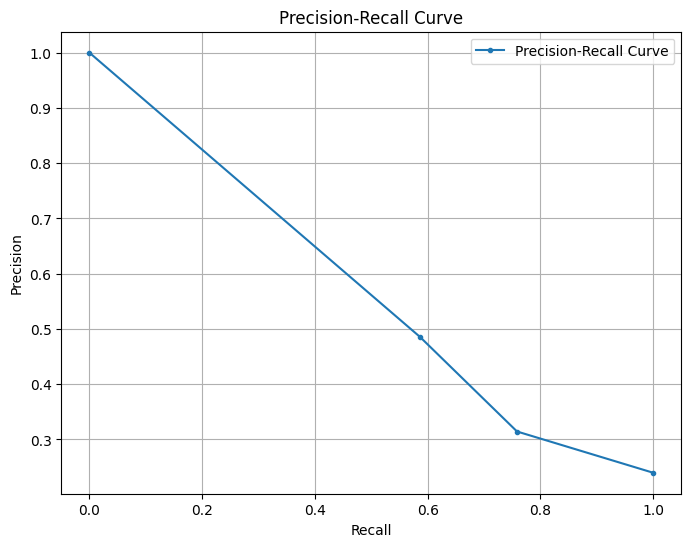

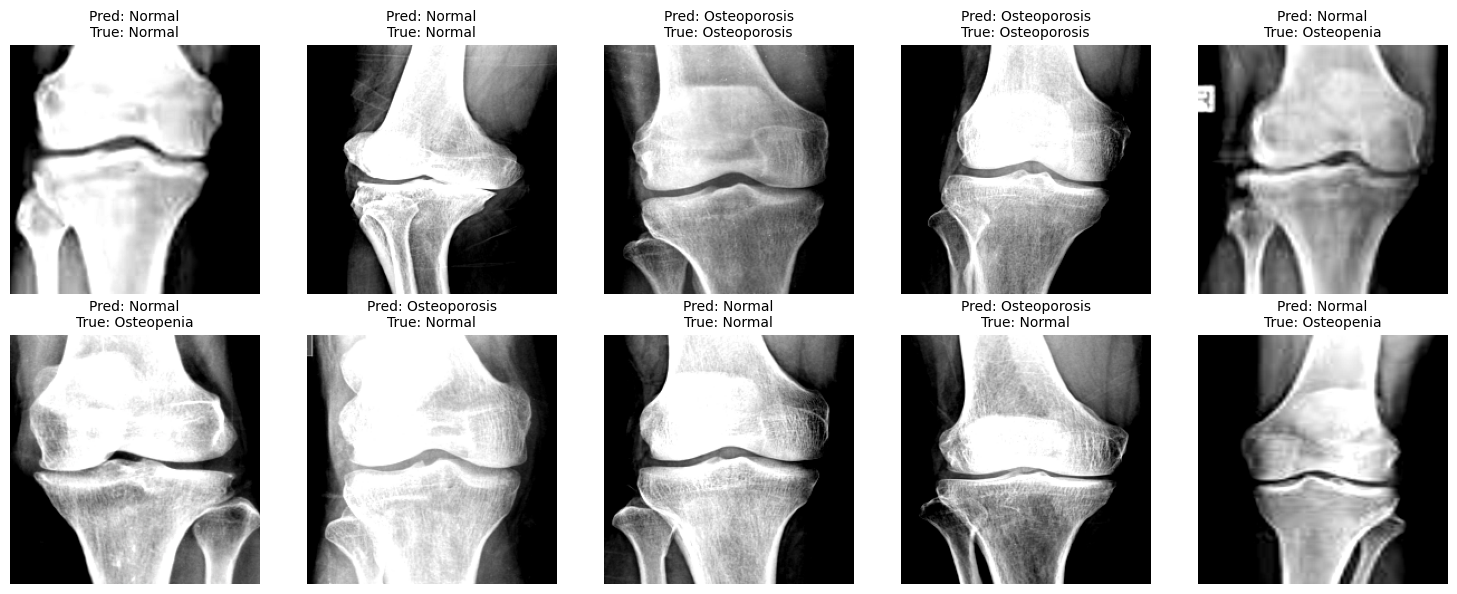


Final Evaluation Summary:
Model          Accuracy  Precision Recall    F1-Score  
AlexNet        0.58      0.59      0.59      0.58      
VGG19          0.51      0.52      0.52      0.51      
ResNet50       0.63      0.62      0.63      0.62      
ViT            0.55      0.53      0.54      0.54      


In [17]:
# Define class names
class_names = ["Normal", "Osteopenia", "Osteoporosis"]

# List of models to evaluate
models = {
    "AlexNet": alexnet,
    "VGG19": vgg19,
    "ResNet50": resnet,
    "ViT": vit
}

# Dictionary to store results
evaluation_results = {}

# Loop through each model and evaluate
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...\n")
    
    # Evaluate model
    accuracy, precision, recall, f1, all_preds, all_labels = evaluate_model(model, val_loader, class_names)
    
    # Store results
    evaluation_results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }
    
    # Plot confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names)

    # Plot Precision-Recall curve
    plot_precision_recall(all_labels, all_preds)

    # Visualize sample predictions
    visualize_predictions(model, val_loader, class_names)

# Print summary of evaluation results
print("\nFinal Evaluation Summary:")
print("=" * 50)
print(f"{'Model':<15}{'Accuracy':<10}{'Precision':<10}{'Recall':<10}{'F1-Score':<10}")
print("=" * 50)

for model_name, metrics in evaluation_results.items():
    print(f"{model_name:<15}{metrics['Accuracy']:<10.2f}{metrics['Precision']:<10.2f}{metrics['Recall']:<10.2f}{metrics['F1-Score']:<10.2f}")

### Ensemble Method

In [18]:
import torch.nn.functional as F

def ensemble_predict(models, inputs):
    outputs = []
    for model in models:
        model.eval()
        with torch.no_grad():
            output = model(inputs).logits if hasattr(model, "logits") else model(inputs)
            outputs.append(F.softmax(output, dim=1))
    
    # Average the predictions
    avg_output = torch.stack(outputs).mean(dim=0)
    _, predicted = torch.max(avg_output, 1)
    
    return predicted, avg_output

In [19]:
import torch.nn.functional as F

def ensemble_predict(models, inputs):
    outputs = []
    
    for model in models:
        model.eval()
        with torch.no_grad():
            output = model(inputs)
            
            # Handle different output structures
            if isinstance(output, torch.Tensor):  # Regular models (AlexNet, VGG19, ResNet)
                logits = output
            elif hasattr(output, "logits"):  # ViT returns an ImageClassifierOutput object
                logits = output.logits
            else:
                raise ValueError("Unexpected model output format")
            
            outputs.append(F.softmax(logits, dim=1))  # Apply softmax to logits

    # Average the predictions from all models
    avg_output = torch.stack(outputs).mean(dim=0)

    # Get the predicted class (highest probability)
    preds = torch.argmax(avg_output, dim=1)

    return preds, avg_output  # Return both predicted class and confidence scores

### Predict on New X-ray Images

In [20]:
def predict_image(image_path, models):
    image = transform(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
    _, probabilities = ensemble_predict(models, image)
    
    class_idx = probabilities.argmax().item()
    class_name = dataset.classes[class_idx]
    
    print(f"Predicted Class: {class_name}")
    print("Class Probabilities:")
    for i, prob in enumerate(probabilities.cpu().numpy()[0]):
        print(f"{dataset.classes[i]}: {prob:.4f}")